# Eigenmode simulation with Ports

Authors: Samarth Hawaldar, Arvind Mamgain

Adapted from tutorial 4.16


In [1]:
# Import useful packages
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs

# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

# Packages for the simple design
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb_driven import LaunchpadWirebondDriven
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
# Analysis
from qiskit_metal.analyses.quantization import EPRanalysis
import pyEPR as epr

In [2]:
import numpy as np

# Set up the design

In [3]:
# Set up chip dimensions 
design = designs.DesignPlanar()
design._chips['main']['size']['size_x'] = '2mm'
design._chips['main']['size']['size_y'] = '2mm'
design._chips['main']['size']['size_z'] = '-280um'
# Resonator and feedline gap width (W) and center conductor width (S) from reference 2
design.variables['cpw_width'] = '10 um' #S from reference 2
design.variables['cpw_gap'] = '6 um' #W from reference 2


design.overwrite_enabled = True

hfss = design.renderers.hfss

# Open GUI
gui = MetalGUI(design)

# Define the geometry

Here we will have a single feedline couple to a single CPW resonator.

The lauchpad should be included in the driven model simulations.

For that reason, we use the LaunchpadWirebondDriven component which has an extra pin for input/output

In [11]:
###################
# Single feedline #
###################

# Driven Lauchpad 1
x = '-0.5mm'
y = '0.5mm'
launch_options = dict(chip='main', pos_x=x, pos_y=y, orientation='360', lead_length='30um')
LP1 = LaunchpadWirebondDriven(design, 'LP1', options = launch_options)

# Driven Launchpad 2
x = '0.5mm'
y = '0.5mm'
launch_options = dict(chip='main', pos_x=x, pos_y=y, orientation='180', lead_length='30um')
LP2 = LaunchpadWirebondDriven(design, 'LP2', options = launch_options)

# coupling resonator to feedline 
q_read = CoupledLineTee(design,'Q_Read_T', options=dict(pos_x = '0.0mm', pos_y = '0.5mm', 
                                                        orientation = '0',
                                                        coupling_space = '6um',                                                         
                                                        coupling_length = '300um',
                                                        open_termination = False))


gui.rebuild()


  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  self._net_info = self._net_info.append(temp_df, ignore_index=True)

  self._net_info = self._net_info.append(temp_df, ignore_index=True)

  su

In [12]:

# Using path finder to connect the two launchpads
TL_LP1_T = RoutePathfinder(design, 'TL_LP1_T', options = dict(chip='main', trace_width ='10um',
        trace_gap ='6um',
                                            fillet='99um',
                                                                  
        hfss_wire_bonds = True,
                                            lead=dict(end_straight='0.1mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='Q_Read_T',
                                                    pin='prime_start')
                                            )))

TL_T_LP2 = RoutePathfinder(design, 'TL_T_LP2', options = dict(chip='main', trace_width ='10um',
        trace_gap ='6um',
                                            fillet='99um',
                                                                  
        hfss_wire_bonds = True,
                                            lead=dict(end_straight='0.1mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q_Read_T',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))
# # Rebuild the GUI

  self._net_info = self._net_info.append(temp_df, ignore_index=True)

  self._net_info = self._net_info.append(temp_df, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  self._net_info = self._net_info.append(temp_df, ignore_index=True)

  self._net_info = self._net_info.append(temp_df, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)



In [13]:
######################
# lambda/4 resonator #
######################

# First we define the two end-points
otg = OpenToGround(design, 'otg', options=dict(chip='main', pos_x='0.0mm',  pos_y='-0.7mm', orientation='-90'))

# Use RouteMeander to fix the total length of the resonator
rt_meander = RouteMeander(design, 'meander',  Dict(
        trace_width ='10um',
        trace_gap ='6um',
        total_length='3.7mm',
        hfss_wire_bonds = True,
        fillet='99 um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg', pin='open'),
            end_pin=Dict(component='Q_Read_T', pin='second_end')), ))

# rebuild the GUI
gui.rebuild()

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  self._net_info = self._net_info.append(temp_df, ignore_index=True)

  self._net_info = self._net_info.append(temp_df, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  super().__setattr__(name, value)

  self.tables[kind] = table.append(df, sort=False, ignore_index=True)

  su

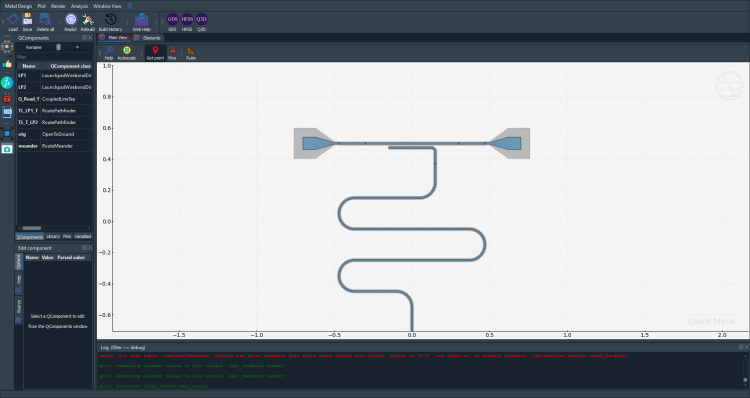

In [14]:
gui.autoscale()
gui.screenshot()

# Perfoming Eigenmode Simulation

In [8]:
from qiskit_metal.analyses.quantization import EPRanalysis
eig_qb = EPRanalysis(design, "hfss")
hfss = eig_qb.sim.renderer
hfss.start()

INFO 04:18PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:18PM [load_ansys_project]: 	Opened Ansys App
INFO 04:18PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 04:18PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/QTLAB/Kunal/OneDrive - Indian Institute of Science/Documents/Ansoft/Directory/
	Project:   Project29
INFO 04:18PM [connect_design]: 	Opened active design
	Design:    HangerReso_hfss [Solution type: Eigenmode]
INFO 04:18PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:18PM [connect]: 	Connected to project "Project29" and design "HangerReso_hfss" 😀 



True

In [21]:
em_p = eig_qb.sim.setup
em_p.name = 'HangerReso'
em_p.min_freq_ghz = 0.1
em_p.n_modes = 1
em_p.max_passes = 15
em_p.max_delta_f = 0.1
em_p.min_converged = 2
em_p.basis_order = 2
# Design variables can also be added in for direct simulation sweeps.
em_p.vars = Dict({'Lj': '0nH', 'Cj': '0 fF'})

In [15]:
eig_qb.sim._render(name="HangerReso",
                selection = [],
                solution_type='eigenmode',
                vars_to_initialize=em_p.vars, 
                open_pins=[], 
                port_list=[('LP1', 'in','50'), ('LP2', 'in','50')],
                box_plus_buffer = False)

INFO 04:19PM [connect_design]: 	Opened active design
	Design:    HangerReso_hfss [Solution type: Eigenmode]


'HangerReso_hfss'

In [16]:
hfss.modeler.mesh_length(
                'fine_mesh',
                ['trace_meander'],
                MaxLength='0.05mm')

In [24]:
eig_qb.sim._analyze()

INFO 04:51PM [get_setup]: 	Opened setup `HangerReso`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:51PM [analyze]: Analyzing setup HangerReso
05:25PM 49s INFO [get_f_convergence]: Saved convergences to d:\Samarth\metal_dev\qiskit-metal\tutorials\4 Analysis\B. Advanced - Direct use of the renderers\hfss_eig_f_convergence.csv


In [25]:
eig_qb.get_frequencies()

Design "HangerReso_hfss" info:
	# eigenmodes    1
	# variations    1
Design "HangerReso_hfss" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,7.229233,2558.02437
